In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision

from datetime import datetime

In [2]:
batch_size = 128
hidden_layers=512
epoch_number = 15
cuda = True

In [3]:
device = 'cuda' if torch.cuda.is_available() and cuda else 'cpu'
print('Device: {}'.format(device))

Device: cuda


In [4]:
train_dataset = torchvision.datasets.FashionMNIST(
    root="../data/",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

test_dataset = torchvision.datasets.FashionMNIST(
    root="../data/",
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

In [5]:
print('Data shape: {}'.format(train_dataset.data.shape))
print('Targets shape: {}'.format(train_dataset.targets.shape))
print('Class types amount: {}'.format(len(set(train_dataset.targets.numpy()))))

Data shape: torch.Size([60000, 28, 28])
Targets shape: torch.Size([60000])
Class types amount: 10


In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
)


In [7]:
class ANN(nn.Module):
    def __init__(self, input_layers, output_layers, hidden_layers=128):
        super(ANN, self).__init__()
        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(input_layers, hidden_layers),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_layers, hidden_layers),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_layers, output_layers),
        )

    def forward(self, inputs):
        outputs = self.dense_layers(inputs)
        return outputs


In [8]:
model = ANN(
    input_layers=28*28,
    output_layers=10,
    hidden_layers=hidden_layers,
)
model.to(device)


ANN(
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

In [26]:
def validate(
    model,
    dataset,
    test_size=256,
    batch_size=128,
    device='cpu',
):
    loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    
    total_correct = 0
    total_tested = 0

    for (inputs, targets) in loader:
        if total_tested >= test_size:
            break
        
        inputs = inputs.to(device).view(-1, 784)
        targets = targets.to(device)

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)
        total_correct += sum(predictions == targets)
        total_tested += len(targets)

    return (total_correct / total_tested).item()


In [27]:
def train(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    epoch_number=10,
    device="cpu",
):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for it in range(epoch_number):
        
        iter_train_loss = []
        iter_test_loss = []

        for (inputs, targets) in train_loader:
            inputs = (inputs.to(device)).view(-1, 784)
            targets = targets.to(device)

            outputs = model(inputs)

            optimizer.zero_grad()

            loss = criterion(outputs, targets)
            loss.backward()

            optimizer.step()
            
            iter_train_loss.append(loss.item())

        train_losses.append(np.mean(iter_train_loss))

        train_accuracies.append(
            validate(
                model=model,
                dataset=train_dataset,
                device=device,
            )
        )

        for (inputs, targets) in test_loader:
            inputs = (inputs.to(device)).view(-1, 784)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, targets)
            
            iter_test_loss.append(loss.item())

        test_losses.append(np.mean(iter_test_loss))

        test_accuracies.append(
            validate(
                model=model,
                dataset=train_dataset,
                device=device,
            )
        )

        print("Iteration {}/{}".format(it + 1, epoch_number))

    return train_losses, test_losses, train_accuracies, test_accuracies


In [28]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    test_loader=test_loader,
    epoch_number=15,
    device=device,
)


Iteration 1/15
Iteration 2/15
Iteration 3/15
Iteration 4/15
Iteration 5/15
Iteration 6/15
Iteration 7/15
Iteration 8/15
Iteration 9/15
Iteration 10/15
Iteration 11/15
Iteration 12/15
Iteration 13/15
Iteration 14/15
Iteration 15/15


<Figure size 432x288 with 0 Axes>

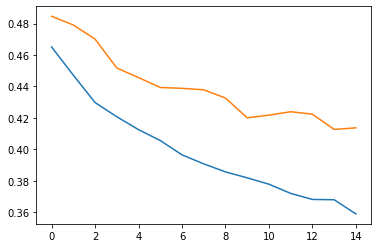

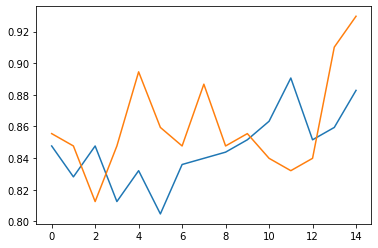

In [29]:
plt.figure(1)
fig, axes = plt.subplots()
axes.plot(train_losses)
axes.plot(test_losses)

plt.figure(2)
fig, axes = plt.subplots()
axes.plot(train_accuracies)
axes.plot(test_accuracies)

In [30]:
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues
):
    """
    This functions prints and plots Confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix without normalization")

    print(cm)

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix without normalization
[[812   4  13  45   9   2 102   0  13   0]
 [  4 957   2  28   4   0   4   0   1   0]
 [ 16   2 720  16 148   0  95   0   3   0]
 [ 21  13  10 859  64   0  29   0   3   1]
 [  0   0  85  32 805   0  78   0   0   0]
 [  0   0   0   1   0 942   0  40   3  14]
 [141   3 102  34 101   0 599   0  20   0]
 [  0   0   0   0   0  39   0 927   0  34]
 [  5   1   4   5   9   4   8   6 958   0]
 [  0   0   0   0   0  14   0  50   1 935]]


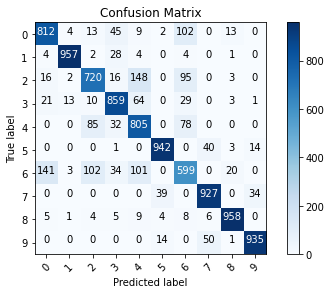

In [32]:
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
    inputs = inputs.to(device).view(-1, 784)
    targets = targets.to(device)

    outputs = model(inputs)

    _, predictions = torch.max(outputs, 1)

    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))
